# Laboratorio 7 (Aprendizaje por refuerzo) Grupo 1
 <h3>Implementacion de Algoritmos de Gradiente<h3>
 <HR>
 <h3>
  NOMBRES:
  
  * POLO ORELLANA BRAYAN SIMON
  * LOPEZ CHIRI DIMAR GABRIEL
  
  <br>
  CARRERA: INGENIERIA DE SISTEMAS
  <BR>
  FECHA: 17/06/2024 <BR>

  * [Enlace de invitacion para ser colaborador](https://github.com/bspoloo/SIS420-012024/invitations)
  
  * [Enlace al git hub](https://github.com/bspoloo/SIS420-012024/tree/main/Laboratorios/Laboratorio%207)

 <h3>

## Algoritmos de Gradiente
"Softmax Action Selection" o "Softmax Policy". En este enfoque, en lugar de seleccionar acciones basadas únicamente en sus valores estimados (como en los métodos $\epsilon$-greedy), se asigna una preferencia Ht(𝑎) a cada accion a. La probabilidad $ \pi_t(a)$ de seleccionar la acción 𝑎 en el tiempo 𝑡 está determinada por la función softmax:

$$
    \pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}
$$

donde 
𝑘 es el número total de acciones disponibles.
​

donde $\tilde{R_t}$ es el promedio de todas las recompensas hasta el instante $t$ (incluído). Este valor actúa como referencia con la que comparamos la recompensa. Si es mayor, la probabilidad de escoger esa acción en el futuro aumenta. Si es menor, la probabilidad se reduce. Las acciones no escogidas, se actualizan en el sentido opuesto.

Si la accion 𝑎 es seleccionada en el tiempo 𝑡 (es decir A𝑡 = 𝑎), su preferencia se actualiza segun:
$$
    \begin{array}{ll}
        H_{t+1}(a) = H_{t}(a) + \alpha(R_t-\tilde{R_t})(1-\pi_t(A_t))
    \end{array}
$$

Para todas las acciones 𝑎 $\neq A_t$

$$
    \begin{array}{ll}
        H_{t+1}(a) = H_{t}(a) - \alpha(R_t-\tilde{R_t})\pi_t(a)
    \end{array}
$$




### Funcionamiento del Algoritmo
* Exploracion y Explotacion: EL algoritmo de Softmax Action Selection permite una exploración suave de las acciones. Las acciones con mayores preferencias $ \begin{array}{ll} H_{t}(a) \end{array} $ tienen una probabilidad 
$ \pi_t(a)$ más alta de ser seleccionadas, pero todas las acciones tienen una probabilidad no nula.

* Adaptacion Dinamica: A medida que el agente recibe recompensas y actualiza las preferencias, las probabilidades $ \pi_t(a)$ se ajustan dinámicamente. Si una acción produce recompensas consistentemente mayores que el promedio $ (\tilde{R_t})$ su probabilidad $ \pi_t(a)$ tiende a aumentar fomentando su seleccion en futuros pasos de tiempo.

## Importacion librerias
importamos las librerias necesarias para la realizacion de este laboratorio:

In [20]:

#Importamos la librería gym para poder utilizar el entorno de OpenAI
import gymnasium as gym
#Importamos la librería numpy para poder trabajar con arrays
import numpy as np
#Importamos la librería matplotlib para poder realizar gráficas
import matplotlib.pyplot as plt 
#Importamos la librería os para poder interactuar con el sistema operativo
import os
#Importamos la función clear_output de la librería IPython.display para poder limpiar la salida de la celda
from IPython.display import clear_output
#Importamos la librería random para poder generar números aleatorios 
import random
#Importamos la librería matplotlib para poder realizar gráficas 
import matplotlib.pyplot as plt
#Importamos la librería pickle para poder guardar los datos en un archivo 
import pickle
#Importamos la librería time para poder utilizar la función sleep
import time
#Importamos la librería pandas para poder trabajar con dataframes 
#Importamos la librería pandas para poder trabajar con dataframes 
import pandas as pd

## Creacion de funcion para graficar las recompensas acumuladas cada episodio
Esta Clase tien la funcion de graficar, el cual toma los parametros de premios por episodio, el numero de episodios:

In [21]:

def Graphic_Average_reward_per_alpha(reward_per_alpha, alphas):
    plt.figure(figsize=(8, 5))
    for alpha in alphas:
        plt.plot(reward_per_alpha[alpha], label=f'alpha = {alpha}')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.title('Recompensa media por episodio para diferentes valores de alpha')
    plt.show()

## Creacion de la funcion Softmax


In [22]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

## Implementacion del Modelo
Para este modelo se crearon dos clases, el `Game` y `Agente`, esto para tener el codigo mas entendible y mas ordenado:

### Game
La clase `Game` contiene sus atributos y metodos, donde nos ayudaran a interactuar con el agente y su entorno para la **exploracion**, **explotacion**, importacion y explotacion del ``agente``:

**Parametros:**
- Agente: esta es la clase principal el cual contiene el entorno, este entorno es el que contiene espacio de estados y un espacio de acciones para que un agente interactúe con él
- Explore: este parametro nos sirve para verifcar que el entorno actual es de exploracion o explotacion, ``False`` y ``True``

**Metodos:**
- is_explore(): esta funcion valida que el agente este en modo exploracion o explotacion:
    * Exploracion: Si el agente esta en modo exploracion inicia la tabla `q` y `actions` del agente en vacio
    * Explotacion: Si el agente esta en modo explotacion caragara el archivo `.pkl` donde esta almacenada una tabla de una exploracion anteriro
- run(): este es el metodo mas importante de la clase `Game`, ya que toma el numero de episodios y ejecuta cada episodo, esta es la parte donde el agente en verdad aprende.

In [23]:
class Game():
    def __init__(self, Agent, explore=True):
        self.agent = Agent
        self.explore = explore
        self.is_explore()
        
    def is_explore(self):
        if self.explore:
            self.agent.H = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
            self.agent.pi = np.array([softmax(self.agent.H[s]) for s in range(self.agent.env.observation_space.n)])
        else:
            self.agent.load_pickle()
        
    def run(self, episodes=100):
        RENDER_AT_EPISODE = 10
        rewards_per_episode = np.zeros(episodes)
        steps_per_episode = np.zeros(episodes)
        
        for episode in range(episodes):
            state = self.agent.reset()
            episode_reward = 0
            episode_steps = 0
            rewards = []
            terminated = False
            truncated = False
            
            while not terminated and not truncated:
                
                action = self.agent.choose_action(state, self.explore)
                # print(f"S: {state}, {action}")s
                next_state, reward, terminated, truncated, _ = self.agent.env.step(action)
                
                if self.explore:
                    rewards.append(reward)
                    baseline = np.mean(rewards)
                    self.agent.update(state, action, reward, baseline)
                
                state = next_state
                episode_reward += reward
                episode_steps += 1
                
            if episode % RENDER_AT_EPISODE == 0:
                clear_output(wait=True)
                self.agent.env.render()
            
            #guardamos la recompensa por episodio en una array
            rewards_per_episode[episode] = episode_reward
            print(f"Episode {episode}/{episodes}, Alpha: {self.agent.alpha:.4f}, Reward: {episode_reward:.4f}")
            
            steps_per_episode[episode] = episode_steps
        self.agent.save_pickle()
        self.close()
        return rewards_per_episode, steps_per_episode
    
    def close(self):
        print("Closing environment")
        if self.agent.env:
            self.agent.env.close()

### Agente
Esta clase tiene es nuestro agente, el que interactua con el entorno del juego, el que toma las acciones:

- Hyperparametros:
    * alpha: $\alpha$ (alpha) es el parámetro de tasa de aprendizaje (learning rate). Este parámetro controla cuánto se actualizan los valores en la tabla Q o la función de valor en cada paso de aprendizaje.

- Variables del Agente:
    * url_pickle: Ruta para guardar o cargar la tabla Q en un archivo pickle.
    * episode_reward: Recompensa acumulada por episodio.
    * env: El entorno en el que opera el agente.
    * action_counts: Cuenta de cuántas veces se ha tomado cada acción en cada estado.
    * H: representa la preferencia de la acción 
𝑎
a en el tiempo 
𝑡
t.

    *   pi:  es la probabilidad de seleccionar la acción 
𝑎
a en el tiempo 
𝑡
t.

    * k es el número total de acciones disponibles.

- Explicación Adicional
    * reset: Restablece el entorno y devuelve el estado inicial.
    * select_best_action: Selecciona la mejor acción posible en un estado dado basado en los valores Q actuales.
    * choose_action: Elige una acción basada en la política $\epsilon$-greedy.
    * Update: Actualiza de la tabla PI de acuerdo a la accion accion
    * save_pickle: Guarda la tabla pi en un archivo.
    * load_pickle: Carga la tabla pi desde un archivo.

In [24]:
class Agent():
    def __init__(self,env, alpha=0.01):
        #hiperparametros
        self.alpha = alpha
        #variables
        self.url_pickle = f"CliffWalking_alpha_{self.alpha}.pkl"
        self.episode_reward = 0
        self.env = env
        self.action_counts = np.zeros((env.observation_space.n, env.action_space.n))
        #variables para la matriz de politicas
        self.H = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.pi = softmax(self.H)
    
    def reset(self):
        return self.env.reset()[0]
    
    def choose_action(self, state, explore):
        if explore:
            return np.random.choice(self.env.action_space.n, p=self.pi[state])
        else:
            return np.argmax(self.pi[state])

    def update(self, state, action, reward, baseline):
        #donde la accion actual es igual a una de las 4 posibles, selecciona una formula de H u otra
        for a in range(self.env.action_space.n):
            if a == action:
                self.H[state][a] += self.alpha * (reward - baseline) * (1 - self.pi[state][a])
            else:
                self.H[state][a] -= self.alpha * (reward - baseline) * self.pi[state][a]
        # actualiza la matriz de politicas, haciendo el uso del softmax
        self.pi[state] = softmax(self.H[state])
    
    def save_pickle(self):
        with open(self.url_pickle, "wb") as f:
            pickle.dump({'H': self.H, 'pi': self.pi}, f)

    def load_pickle(self):
        print("Loading pickle")
        try:
            with open(self.url_pickle, 'rb') as f:
                data = pickle.load(f)
                self.H = data['H']
                self.pi = data['pi']
        except FileNotFoundError:
            print(f"Pickle file {self.url_pickle} not found. Using default values.")

## Exploracion del agente
La exploracion del agente consiste en probar diferentes acciones para descubrir cuáles resultan en las mejores recompensas a largo plazo. Es un componente crucial en la estrategia de aprendizaje porque permite al agente evitar quedarse atrapado en una solución subóptima que puede parecer buena en el corto plazo pero no lo es a largo plazo.

En esta parte haremos que diferentes agentes con diferentes valores de alpha, exploren el entorno del `CliffWalking`, y almacenaremos las mejores probabilidades de seleccionar la accion a en el tiempo o estado actual

In [25]:
#los valores de alpha que se van a probar
alphas = [0.01, 0.009, 0.0001]
average_reward_per_alpha = {}
reward_per_episode = {}

#Creamos un diccionario para guardar los diferentes games
games = {}
#variable para renderizar el entorno
render = False
#Creamos el entorno
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)

# #Interamos por cada alpha, un nuevo agente y lo guardamos en el diccionario de games
for alpha in alphas:
    agent = Agent(env, alpha)
    game = Game(agent, explore=True)
    games[alpha] = game

# Para cada alpha, corremos el juego y guardamos la recompensa por episodio, y obtenemos la recompensa promedio por alpha
for alpha, game in games.items():
    #cada juego se corre 1000 veces
    episodes = 200
    rewards_per_episode, _ = game.run(episodes)
    reward_per_episode[alpha] = rewards_per_episode
    average_reward_per_alpha[alpha] = rewards_per_episode / episodes

Episode 10/200, Alpha: 0.0090, Reward: -293.0000
Episode 11/200, Alpha: 0.0090, Reward: -490.0000
Episode 12/200, Alpha: 0.0090, Reward: -466.0000
Episode 13/200, Alpha: 0.0090, Reward: -450.0000
Episode 14/200, Alpha: 0.0090, Reward: -351.0000
Episode 15/200, Alpha: 0.0090, Reward: -491.0000
Episode 16/200, Alpha: 0.0090, Reward: -338.0000
Episode 17/200, Alpha: 0.0090, Reward: -1207.0000
Episode 18/200, Alpha: 0.0090, Reward: -405.0000


KeyboardInterrupt: 

#### Analisi de graficas de exploracion
- Para alpha 0: se puede observar que el las recompensas acumuladas por episodo para episilon 0, son nulas, esto debido a que el agente tuvo probabilidad de exploracion de 0, lo cual hizo que el agente siempre escoja acciones aleatorias:
- Para alpha 1: se puede observar que el agente tuvo demasiadas perdidas, mientras mas episodios hacia, esto es debido a que iba aprendiendo con cada episodio, cada erro, pero seguro incrementara con mas episodios.


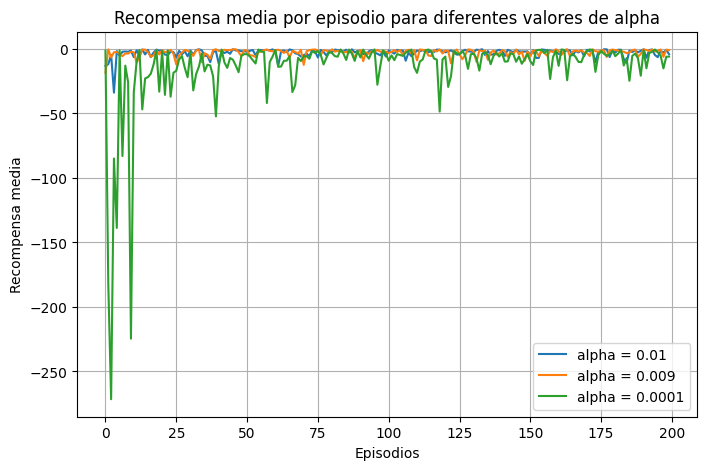

In [13]:
Graphic_Average_reward_per_alpha( average_reward_per_alpha, alphas)

## Explotacion del agente entrenado
Aqui se analizara o mostrara como es que el agente aprendio en todo el entornod de exploracion, cargando el archivo `.pkl` guardado anteriormente en la exploracion.

El agente cuenta con los siguientes estados y acciones:
- Estados: cuenta con 47 acciones, donde cada estado cuenta con una recompensa:
    * Precipicio = -100
    * Espacio normal = -10
- Acciones: cuenta con las siguientes acciones

    * 0: Move up
    * 1: Move right
    * 2: Move down
    * 3: Move left

In [ ]:
render = True
explore = False
alpha = 0.009
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)
agent = Agent(env, alpha)
game = Game(agent, explore= False)
game.run(2)

### Visualizacion de tabla Q
De acuerdo al alpha con el que el agente fue entrenado podemos visualizar la tabla Q del agente donde se muestra el 4 acciones para 47 estados:

In [16]:
q_df = pd.DataFrame(games[0.01].agent.pi)
print("Q-table as DataFrame:")
q_df

Q-table as DataFrame:


,0,1,2,3
0,0.232231,0.222517,0.254070,0.291182
1,0.236871,0.252100,0.250224,0.260805
2,0.249177,0.259517,0.244350,0.246956
3,0.285493,0.243357,0.237347,0.233803
4,0.241448,0.232810,0.256654,0.269088
5,0.257702,0.259068,0.245756,0.237475
6,0.234661,0.261688,0.259152,0.244499
7,0.242872,0.257337,0.250921,0.248871
8,0.235560,0.244897,0.269445,0.250098
9,0.267649,0.256547,0.239755,0.236049
